In [98]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import Constraint
import logging

In [99]:
%matplotlib inline

logging.basicConfig(level="INFO")

In [100]:
prod=pd.read_csv("RESMVLVPROD_20201001_20201031 (1).csv")
# Convert the date and hour columns to strings
prod['DATE'] = prod['DATE'].astype(str)
prod['HOUR'] = prod['HOUR'].astype(str)
# Pad the hour values with leading zeros if necessary
prod['HOUR'] = prod['HOUR'].str.zfill(2)
# Adjust hour '24' to '00' and increment the date by one DATE
prod.loc[prod['HOUR'] == '24', 'HOUR'] = '00'
prod['DATE'] = pd.to_datetime(prod['DATE'], format='%Y%m%d')
prod.loc[prod['HOUR'] == '00', 'DATE'] += pd.DateOffset(days=1)
prod['DATE'] = prod['DATE'].dt.strftime('%Y-%m-%d')
prod['datetime'] = prod['DATE'] + ' ' + prod['HOUR'] + ':00:00'
prod['datetime'] = pd.to_datetime(prod['datetime'])
prod.set_index(['datetime'],inplace=True)
start_date = pd.Timestamp('2020-10-25 00:00:00')
end_date = pd.Timestamp('2020-10-31 23:00:00')
prod=prod[start_date:end_date]
prod['ENERGY(MWh)']=prod['ENERGY(MWh)']/2000
prod


,DATE,HOUR,ENERGY(MWh)
datetime,,,
2020-10-25 00:00:00,2020-10-25,00,0.062189
2020-10-25 01:00:00,2020-10-25,01,0.061279
2020-10-25 02:00:00,2020-10-25,02,0.061284
2020-10-25 03:00:00,2020-10-25,03,0.060697
2020-10-25 04:00:00,2020-10-25,04,0.059399
...,...,...,...
2020-10-31 19:00:00,2020-10-31,19,0.078057
2020-10-31 20:00:00,2020-10-31,20,0.084492
2020-10-31 21:00:00,2020-10-31,21,0.083528


In [101]:
cons = pd.read_csv("HVCUSTCONS_20201001_20201031 (1).csv")
#20201025,25,724.9618378,37.28140312

# Convert the date and hour columns to strings
cons['date'] = cons['date'].astype(str)
cons['hour'] = cons['hour'].astype(str)

# Pad the hour values with leading zeros if necessary
cons['hour'] = cons['hour'].str.zfill(2)

# Adjust hour '24' to '00' and increment the date by one day
cons.loc[cons['hour'] == '24', 'hour'] = '00'
cons['date'] = pd.to_datetime(cons['date'], format='%Y%m%d')
cons.loc[cons['hour'] == '00', 'date'] += pd.DateOffset(days=1)
cons['date'] = cons['date'].dt.strftime('%Y-%m-%d')

# Merge the date and hour columns
cons['datetime'] = cons['date'] + ' ' + cons['hour'] + ':00:00'

# Optionally, convert the 'datetime' column to a datetime data type
cons['datetime'] = pd.to_datetime(cons['datetime'])
cons.set_index(['datetime'],inplace=True)
start_date = pd.Timestamp('2020-10-25 00:00:00')
end_date = pd.Timestamp('2020-10-31 23:00:00')
cons=cons[start_date:end_date]
cons['energy(MWh)']=cons['energy(MWh)']/1000
#cons

In [102]:
network = pypsa.Network()
network.set_snapshots(prod.index)
#network.snapshots

In [103]:
network.add("Bus", "Coal", carrier='AC')
network.add("Carrier", "coal", co2_emissions=0.2)

#network.add("Bus", "Solar", carrier="AC")
#network.add("Carrier", "Solar")

#network.add("Bus","Load Bus")

#network.add("Line","Line1",bus0="Coal",bus1="Load Bus",r=0.01,x=0.1)
#network.add("Line","Line2",bus0="Solar",bus1="Load Bus",r=0.01,x=0.1)

network.add("GlobalConstraint", "co2_limit", sense="<=", constant=0.0)

network.add(
    "Generator",
    "Coal Gen",
    bus="Coal",
    carrier="coal",
    p_nom=1, #MW 
    p_nom_extendable=False,
    #committable=True,
    p_set=1,
    #p_max_pu=1,
    p_min_pu=0,
    control="PQ",
    capital_cost=100, #currency/MW
    #marginal_cost=  #currency/MWh 
    )

network.add(
    "Generator",
    "PV Park",
    bus="Coal",
    #carrier="Solar",
    control="PQ",
    p_nom=1, #MW 
    p_nom_extendable=True,
    p_set=np.array(prod['ENERGY(MWh)']),
    p_max_pu=np.array(prod['ENERGY(MWh)']),
    p_min_pu=np.array(prod['ENERGY(MWh)']),
    capital_cost=300, #currency/MW
    #marginal_cost=  #currency/MWh
    #p=max_pu * p_nom   
    )

network.add("Load", "load 1", bus="Coal", p_set=np.array(cons['energy(MWh)']))
#network.add("Store", "store", bus="Solar", carrier="Solar", e_initial=True, e_nom_extendable=True)


In [104]:
network.lpf()
#network.optimize()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2020-10-25 00:00:00', '2020-10-25 01:00:00',
               '2020-10-25 02:00:00', '2020-10-25 03:00:00',
               '2020-10-25 04:00:00', '2020-10-25 05:00:00',
               '2020-10-25 06:00:00', '2020-10-25 07:00:00',
               '2020-10-25 08:00:00', '2020-10-25 09:00:00',
               ...
               '2020-10-31 14:00:00', '2020-10-31 15:00:00',
               '2020-10-31 16:00:00', '2020-10-31 17:00:00',
               '2020-10-31 18:00:00', '2020-10-31 19:00:00',
               '2020-10-31 20:00:00', '2020-10-31 21:00:00',
               '2020-10-31 22:00:00', '2020-10-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=168, freq=None)


In [105]:
network.iplot()

{'data': [{'x': Coal    0.0
   Name: x, dtype: float64,
   'y': Coal    0.0
   Name: y, dtype: float64,
   'text': Index(['Bus Coal'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}}],
 'layout': {'title': '',
  'hovermode': 'closest',
  'showlegend': False,
  'shapes': []}}

In [106]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator
Bus,,,,,,,,,,,,
Coal,1.0,,0.0,0.0,AC,,1.0,0.0,inf,Slack,0,Coal Gen


In [107]:
network.loads_t.p

Load,load 1
snapshot,
2020-10-25 00:00:00,0.772726
2020-10-25 01:00:00,0.799781
2020-10-25 02:00:00,0.814007
2020-10-25 03:00:00,0.807890
2020-10-25 04:00:00,0.800132
...,...
2020-10-31 19:00:00,0.736014
2020-10-31 20:00:00,0.744146
2020-10-31 21:00:00,0.765764


In [108]:
network.generators_t.p

Generator,Coal Gen,PV Park
snapshot,,
2020-10-25 00:00:00,0.710536,0.062189
2020-10-25 01:00:00,0.738502,0.061279
2020-10-25 02:00:00,0.752723,0.061284
2020-10-25 03:00:00,0.747193,0.060697
2020-10-25 04:00:00,0.740733,0.059399
...,...,...
2020-10-31 19:00:00,0.657957,0.078057
2020-10-31 20:00:00,0.659654,0.084492
2020-10-31 21:00:00,0.682236,0.083528


In [109]:
network.generators.loc["Coal Gen"]

attribute
bus                      Coal
control                 Slack
type                         
p_nom                     1.0
p_nom_extendable        False
p_nom_min                 0.0
p_nom_max                 inf
p_min_pu                  0.0
p_max_pu                  1.0
p_set                     1.0
q_set                     0.0
sign                      1.0
carrier                  coal
marginal_cost             0.0
build_year                  0
lifetime                  inf
capital_cost            100.0
efficiency                1.0
committable             False
start_up_cost             0.0
shut_down_cost            0.0
min_up_time                 0
min_down_time               0
up_time_before              1
down_time_before            0
ramp_limit_up             NaN
ramp_limit_down           NaN
ramp_limit_start_up       1.0
ramp_limit_shut_down      1.0
p_nom_opt                 0.0
Name: Coal Gen, dtype: object

<Axes: xlabel='snapshot', ylabel='ΜW'>

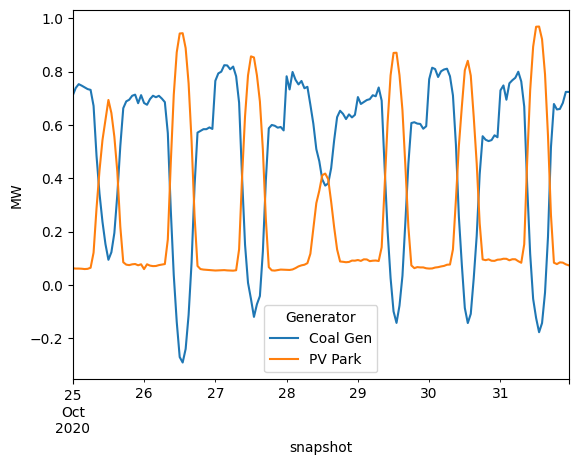

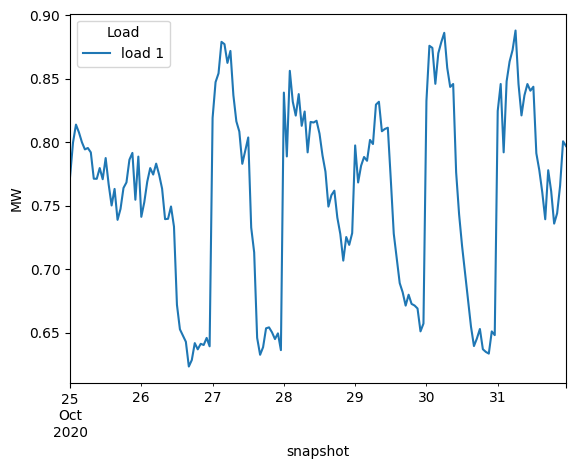

In [110]:
network.generators_t.p.plot(ylabel='ΜW')
network.loads_t.p.plot(ylabel='ΜW')